# Paper to Audio

This notebook will take in an HTML file of a paper and parse it into an audio book.
TTS is generated through Kokoro.

In [58]:
from bs4 import BeautifulSoup
import re
from typing import List, Dict

def clean_text(text: str) -> str:
    """Clean text by removing non-ASCII characters and multiple spaces."""
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    return ' '.join(text.split())

def process_paragraph(p_tag) -> str:
    """Process a paragraph tag by removing unwanted elements and cleaning text."""
    # Remove math and cite tags
    for tag in p_tag.find_all(['math', 'cite']):
        tag.decompose()
    
    text = clean_text(p_tag.get_text(strip=False))
    return text

def process_abstract(soup) -> Dict[str, str]:
    """Extract and process the abstract section."""
    abstract = soup.find('div', class_='ltx_abstract')
    if not abstract:
        return None
    
    abstract_paras = []
    for p in abstract.find_all('p', class_='ltx_p'):
        text = process_paragraph(p)
        if text:
            abstract_paras.append(text)
    
    return {
        "title": "Abstract",
        "content": "\n".join(abstract_paras)
    }

def process_section(section) -> Dict[str, str]:
    """Process a single section and return its title and content."""
    # Extract title
    title_tag = section.find('h2', class_='ltx_title_section')
    title = title_tag.get_text(strip=True) if title_tag else "No Title"
    title = re.sub(r'^\d+', '', title)
    
    # Process paragraphs
    paragraphs = []
    for p in section.find_all('p', class_='ltx_p'):
        text = process_paragraph(p)
        if text:
            paragraphs.append(text)
    
    return {
        "title": title.strip(),
        "content": "\n".join(paragraphs)
    }

def parse_paper_html(file_path_or_url: str, is_url: bool = False) -> List[Dict[str, str]]:
    """Main function to parse the paper HTML and return structured content."""
    # Read and parse HTML
    if is_url:
        import requests
        html = requests.get(file_path_or_url).text
    else:
        with open(file_path_or_url, "r") as f:
            html = f.read()
    soup = BeautifulSoup(html, 'html.parser')
    
    # Initialize result list 
    section_list = []
    
    # Get HTML title
    title_info = []
    title_tag = soup.find('title')
    if title_tag:
        title_info.append({
            "title": "Title",
            "content": clean_text(title_tag.get_text())
        })
    
    # Process abstract
    abstract_section = process_abstract(soup)
    if abstract_section:
        section_list.append(abstract_section)
    
    # Process main sections
    sections = soup.find_all('section', class_='ltx_section')
    for section in sections:
        section_data = process_section(section)
        section_list.append(section_data)
    
    return section_list, title_info

file_path = "/home/iris/wsl_shared/paper_audio_book_generation/src_data/DeepSeek-V3 Technical Report.html"
section_list, title_info = parse_paper_html(file_path)

# # Print sections for verification
# for section in section_list:
#     print(f"\n=== {section['title']} ===")
#     print(f"Content length: {len(section['content'])} characters")


In [59]:
file_path_or_url = 'https://arxiv.org/html/2411.19799v1'
section_list, title_info = parse_paper_html(file_path_or_url, is_url=True)

# # Print sections for verification
# for section in section_list:
#     print(f"\n=== {section['title']} ===")
#     print(f"Content length: {len(section['content'])} characters")

title_info

[{'title': 'Title',
  'content': 'Include: Evaluating Multilingual Language Understanding with Regional Knowledge'}]

In [60]:
section_list[3]["content"]

'Include is a dataset of 197,243 MCQA pairs from 1,926 examinations across 44 languages and 15 scripts. These examinations are collected from local sources in 52 countries, representing a rich array of cultural and regional knowledge. All questions in the dataset are presented in their native languages and scripts. In this section, we describe the data collection procedure for Include, as well as additional categorical labels we assign to each question in the dataset for later analysis.\nTo construct Include, we collect sources of multiple-choice exams in collaboration with native speakers and regional associations. We primarily focused on three types of exams:\nAcademic Exams: Exams from a variety of subjects (e.g., Humanities, STEM, etc.) at different levels (e.g., middle & high school, university), including country-specific national entrance exams.\nProfessional Certifications & Licenses: Exams issued by industry-specific regulatory bodies for specialized fields, e.g., licensing ex

In [61]:
from kokoro.models import build_model
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL = build_model('kokoro/kokoro-v0_19.pth', device)
VOICE_NAME = [
    'af', # Default voice is a 50-50 mix of Bella & Sarah
    'af_bella', 'af_sarah', 'am_adam', 'am_michael',
    'bf_emma', 'bf_isabella', 'bm_george', 'bm_lewis',
    'af_nicole', 'af_sky',
][0]
VOICEPACK = torch.load(f'kokoro/voices/{VOICE_NAME}.pt', weights_only=True).to(device)
print(f'Loaded voice: {VOICE_NAME}')

KeyboardInterrupt: 

In [10]:
from kokoro.kokoro import generate
import nltk
import numpy as np
import soundfile as sf
from tqdm import tqdm
# Download the punkt tokenizer if you haven't already
nltk.download('punkt')

def text_to_audio(text, model, voicepack, voice_name):
    """Generate audio for a single piece of text"""
    audio, _ = generate(model, text, voicepack, lang=voice_name[0])
    return audio

def process_sections(section_list, model, voicepack, voice_name):
    # Initialize empty list to store audio arrays
    audio_segments = []
    
    for section in section_list:
        print(f"Procssing Section title: {section['title']}")
        # Generate audio for the title
        title_audio = text_to_audio(section["title"], model, voicepack, voice_name)
        audio_segments.append(title_audio)
        
        # Add a short pause after the title
        silence = np.zeros(12000)  # 1 second silence at 24kHz
        audio_segments.append(silence)
        
        # Split content into sentences
        sentences = nltk.sent_tokenize(section["content"])
        
        # Generate audio for each sentence
        for sentence in tqdm(sentences):
            # print(sentence)
            try:
                sentence_audio = text_to_audio(sentence, model, voicepack, voice_name)
            except:
                # Split sentence by commas
                parts = sentence.split(',')
                parts = [part.strip() for part in parts if part.strip()]  # Remove empty parts and whitespace
                
                # Initialize array for combined audio
                audio_parts = []
                
                # Process each part separately
                for part in parts:
                    part_audio = text_to_audio(part, model, voicepack, voice_name)
                    audio_parts.append(part_audio)
                
                # Concatenate all parts
                sentence_audio = np.concatenate(audio_parts)
            audio_segments.append(sentence_audio)

            
            # Add a short pause between sentences
            silence = np.zeros(12000)  # 0.5 second silence
            audio_segments.append(silence)
            
        # Add a longer pause between sections
        section_silence = np.zeros(24000)  # 2 seconds silence
        audio_segments.append(section_silence)
    
    # Concatenate all audio segments
    combined_audio = np.concatenate(audio_segments)
    return combined_audio

# Main execution
def generate_audiobook(section_list, model, voicepack, voice_name, output_path):
    # Process all sections and get combined audio
    final_audio = process_sections(section_list, model, voicepack, voice_name)
    
    # Save as WAV file first
    wav_path = output_path.replace('.mp3','.wav')
    sf.write(wav_path, final_audio, 24000)
    
    # Convert to MP3 using pydub
    from pydub import AudioSegment
    audio = AudioSegment.from_wav(wav_path)
    audio.export(output_path, format="mp3")
    
    # Remove temporary WAV file
    import os
    os.remove(wav_path)
    print(f"Audio book has been saved to {output_path}")
    return final_audio

# Usage example:

# Assuming you have MODEL, VOICEPACK, and VOICE_NAME defined as in your notebook
output_file = "audiobook2.mp3"
final_audio = generate_audiobook(section_list, MODEL, VOICEPACK, VOICE_NAME, output_file)



[nltk_data] Downloading package punkt to /home/iris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Procssing Section title: Abstract


100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Procssing Section title: Introduction


100%|██████████| 18/18 [00:02<00:00,  6.01it/s]


Procssing Section title: Preliminaries: Language & Knowledge


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Procssing Section title: TheIncludebenchmark


100%|██████████| 51/51 [00:09<00:00,  5.64it/s]


Procssing Section title: Experimental Setup


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Procssing Section title: Results & Analysis


100%|██████████| 65/65 [00:13<00:00,  4.73it/s]


Procssing Section title: Related work


100%|██████████| 23/23 [00:03<00:00,  5.84it/s]


Procssing Section title: Conclusion


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Procssing Section title: Ethics Statement


100%|██████████| 15/15 [00:02<00:00,  6.59it/s]


Procssing Section title: Reproducibility Statement


100%|██████████| 4/4 [00:00<00:00,  6.80it/s]


Procssing Section title: Acknowledgements


100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Audio book has been saved to audiobook2.mp3


In [11]:
# from IPython.display import display, Audio

# display(Audio(data=final_audio, rate=24000, autoplay=True))

### Transform to MP4 for YouTube

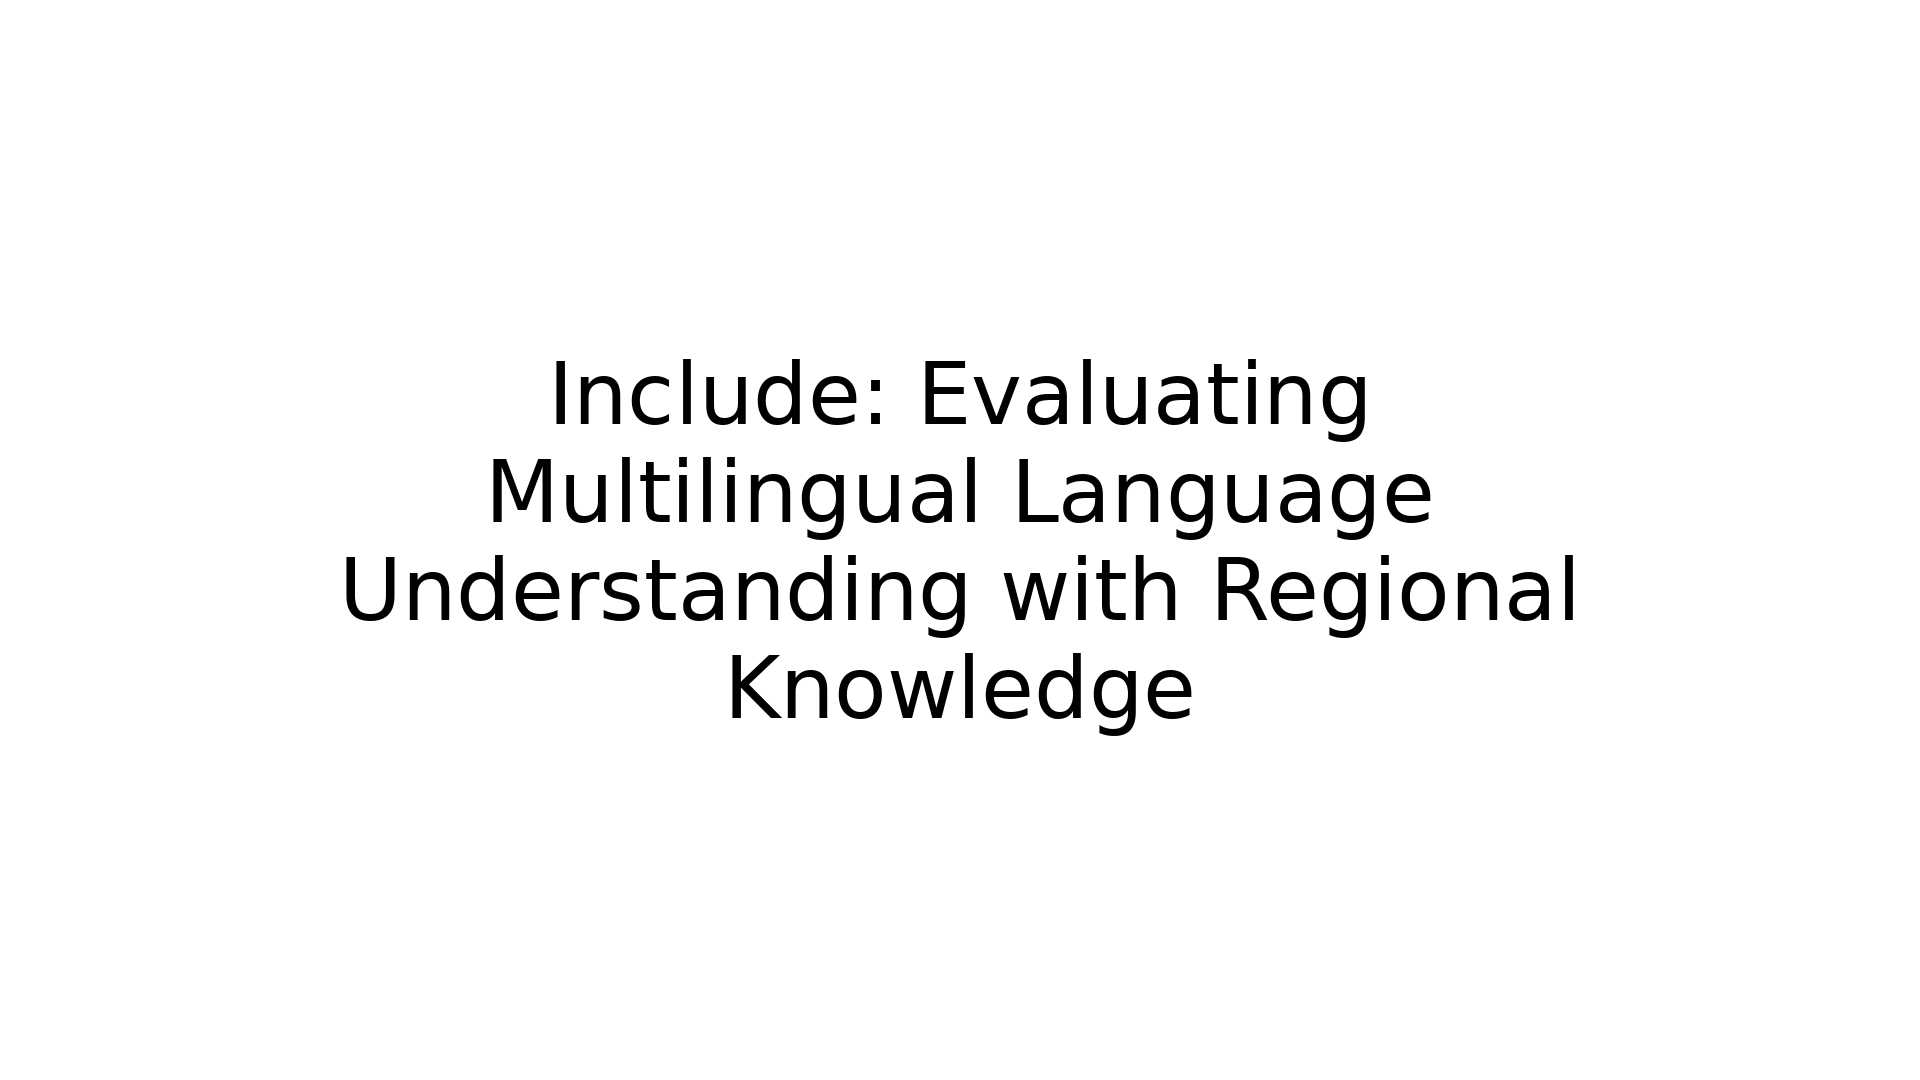

In [ ]:

from PIL import Image, ImageDraw, ImageFont
import textwrap

def create_image_with_text(text, width=1920, height=1080, font_path="DejaVuSans.ttf"):
    # Calculate dynamic font size (roughly 5% of image height)
    font_size = int(height * 0.08)  # Adjust multiplier as needed
    margin = int(width * 0.1)  # 10% margin of image width

    # Load TrueType font with dynamic size
    try:
        font = ImageFont.truetype(font_path, font_size)
    except:
        font = ImageFont.load_default()
        font_size = 12  # fallback size

    # Create a new image with white background
    image = Image.new('RGB', (width, height), 'white')
    draw = ImageDraw.Draw(image)

    # Calculate wrapping with new font size
    max_width = width - 2 * margin
    test_text = 'x' * 50
    test_bbox = draw.textbbox((0, 0), test_text, font=font)
    avg_char_width = test_bbox[2] / 50
    chars_per_line = int((max_width) / avg_char_width)
    wrapped_text = textwrap.fill(text, width=chars_per_line)

    # Rest of your existing drawing code...
    lines = wrapped_text.split('\n')
    line_height = font.getbbox('hg')[3]
    total_text_height = line_height * len(lines)
    start_y = (height - total_text_height) / 2

    # Draw each line centered
    for i, line in enumerate(lines):
        line_bbox = draw.textbbox((0, 0), line, font=font)
        line_width = line_bbox[2] - line_bbox[0]
        x = (width - line_width) / 2
        y = start_y + i * line_height
        draw.text((x, y), line, font=font, fill='black')

    return image

# Define the text
text = title_info[0]['content']

# Create the image
image = create_image_with_text(text)
image.show()

In [ ]:
import re

title_text = title_info[0]['content']
output_name = f"{re.sub(r'[^a-zA-Z0-9]', '_', title_text)}"

In [63]:
from moviepy.editor import ImageClip, AudioFileClip, CompositeVideoClip

def create_image_clip(image, duration=5):
    # Convert bytes to PIL Image
    # image = Image.open(image)
    # Convert PIL Image to ImageClip
    clip = ImageClip(np.array(image)).set_duration(duration)
    return clip

title_clip = create_image_clip(image)


# image_clip = ImageClip("src_data/DeepSeek-V3TechnicalReport.png")
audio_clip = AudioFileClip(f"{output_name}.mp3")
video = title_clip.set_audio(audio_clip)
video = video.set_duration(audio_clip.duration)
video.write_videofile(f"{output_name}.mp4", fps=0.01)

t: 100%|██████████| 1/1 [01:29<00:00, 89.83s/it, now=None]

Moviepy - Building video Include__Evaluating_Multilingual_Language_Understanding_with_Regional_Knowledge.mp4.
MoviePy - Writing audio in Include__Evaluating_Multilingual_Language_Understanding_with_Regional_KnowledgeTEMP_MPY_wvf_snd.mp3


t: 100%|██████████| 1/1 [01:47<00:00, 107.54s/it, now=None]

MoviePy - Done.
Moviepy - Writing video Include__Evaluating_Multilingual_Language_Understanding_with_Regional_Knowledge.mp4



t: 100%|██████████| 1/1 [01:48<00:00, 108.49s/it, now=None]

Moviepy - Done !
Moviepy - video ready Include__Evaluating_Multilingual_Language_Understanding_with_Regional_Knowledge.mp4
